In [1]:
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

from enfify.enf_estimation import segmented_freq_estimation_DFT1, segmented_phase_estimation_hilbert
from enfify.preprocessing import downsample_ffmpeg, bandpass_filter
from enfify.enf_enhancement import RFA, VMD

In [2]:
noise_fs, down_sig_noise = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_noise/1min_noisy_down/down_min_003.wav')
cut_noise_fs, cut_down_sig_noise = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_noise/1min_noisy_down_cut/down_cut_min_003.wav')
ref_fs, down_sig_ref = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data/min_001_ref.wav')

n_noise = np.arange(len(down_sig_noise))
n_noise_cut = np.arange(len(cut_down_sig_noise))
n_ref = np.arange(len(down_sig_ref))

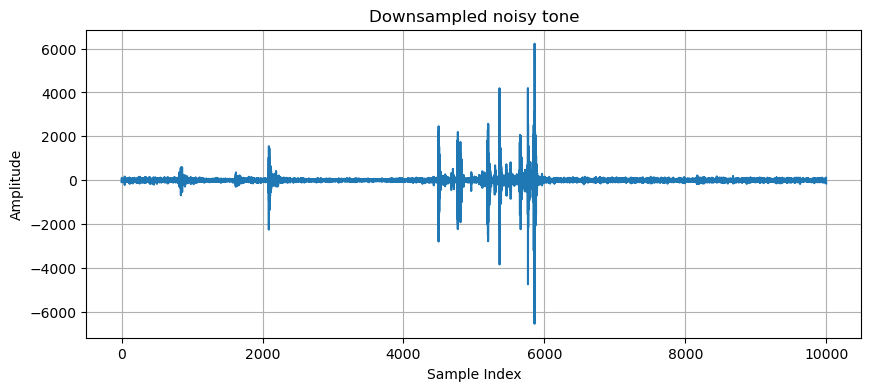

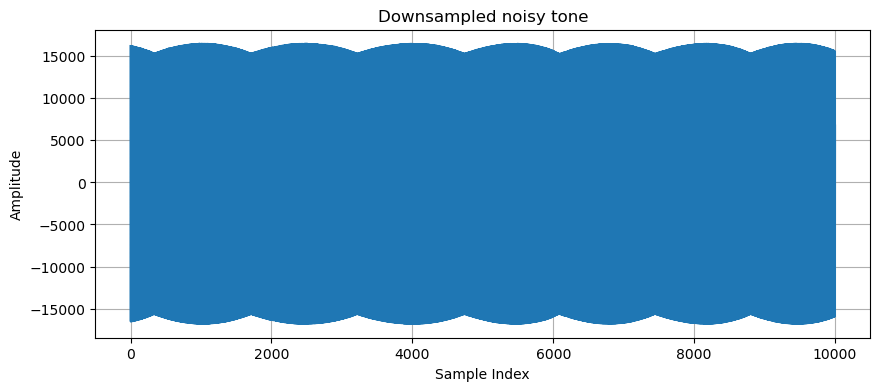

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(n_noise[:10_000], down_sig_noise[:10_000])
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref[:10_000], down_sig_ref[:10_000])
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

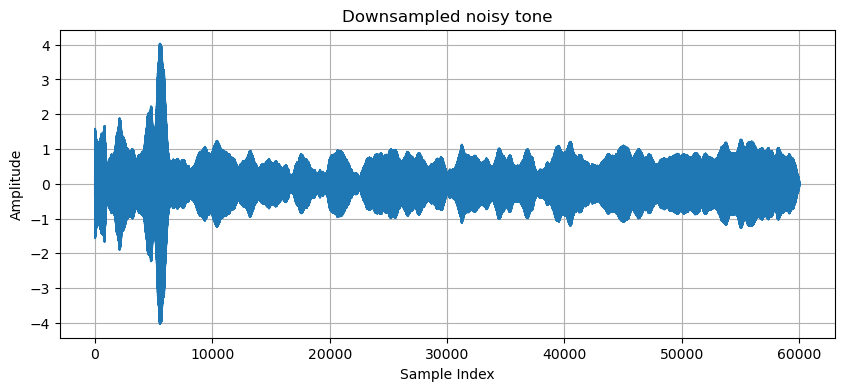

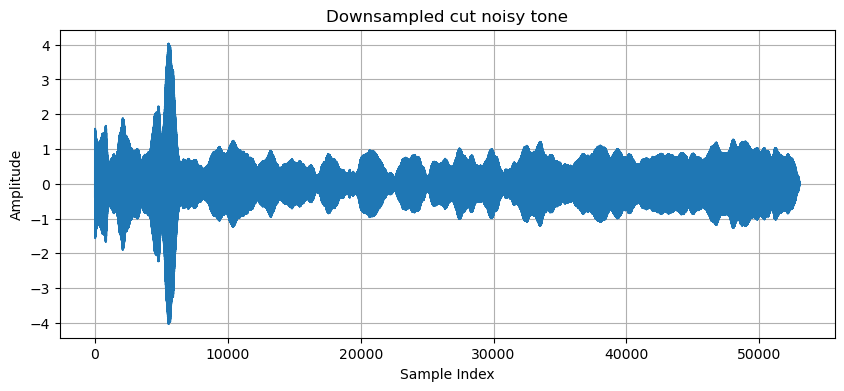

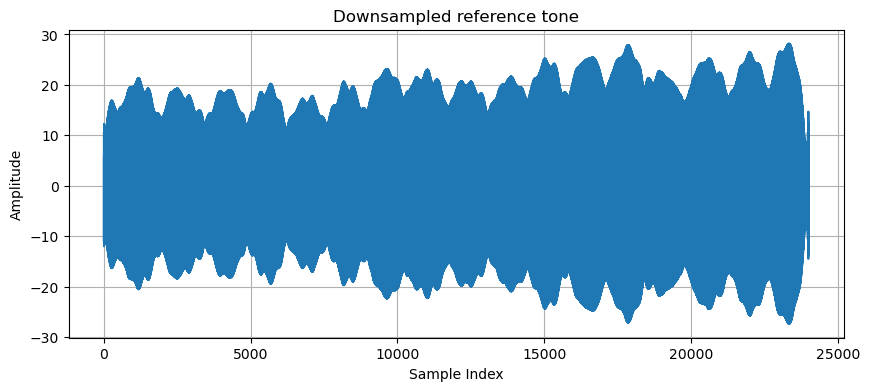

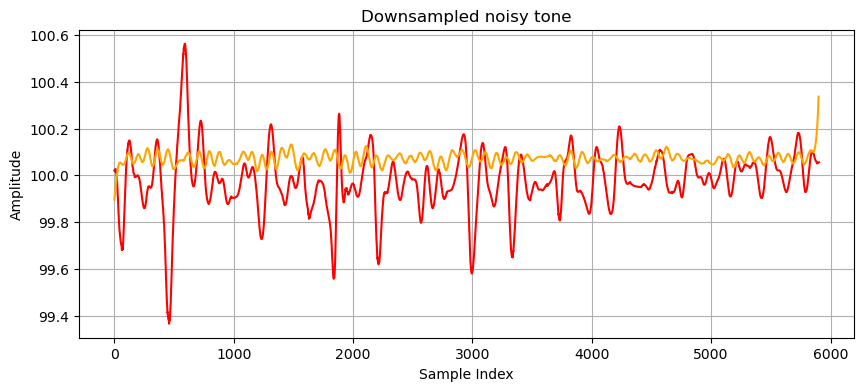

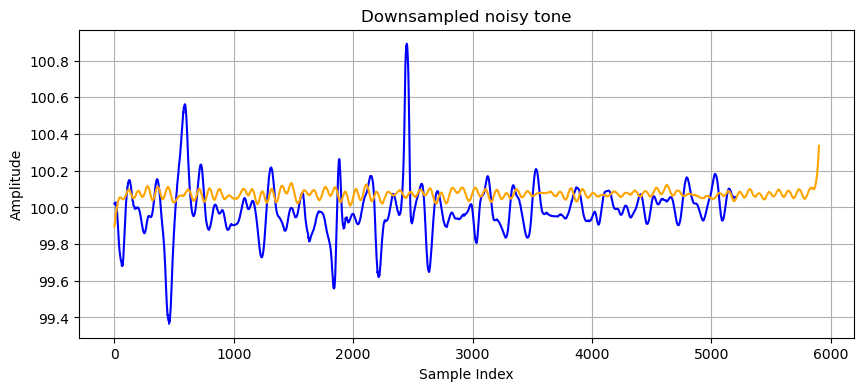

In [4]:
lowcut = 99.5
highcut = 100.5
bandpass_sig = bandpass_filter(down_sig_noise, lowcut, highcut, noise_fs, 1)
bandpass_sig_cut = bandpass_filter(cut_down_sig_noise, lowcut, highcut, noise_fs, 1)
bandpass_ref = bandpass_filter(down_sig_ref, lowcut, highcut, ref_fs, 1)

plt.figure(figsize=(10, 4))
plt.plot(n_noise, bandpass_sig)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_noise_cut, bandpass_sig_cut)
plt.title('Downsampled cut noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref, bandpass_ref)
plt.title('Downsampled reference tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

freqs_DFT1_cut = segmented_freq_estimation_DFT1(bandpass_sig_cut, cut_noise_fs, 100, 20_000, 100)
freqs_DFT1 = segmented_freq_estimation_DFT1(bandpass_sig, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [5]:
for i in tqdm(range(5)):    
    alpha =  5000            # Balancing parameter of the data-fidelity constraint
    tau = 0                 # Noise-tolerance (no strict fidelity enforcement)
    n_mode = 1              # Number of modes to be recovered
    DC = 0
    tol =1e-7    # Tolerance of convergence criterion

    u_clean, _, _ = VMD(bandpass_sig, alpha, tau, n_mode, DC, tol)
    bandpass_sig = u_clean[0]

    u_clean_cut, _, _ = VMD(bandpass_sig_cut, alpha, tau, n_mode, DC, tol)
    bandpass_sig_cut = u_clean_cut[0]


100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


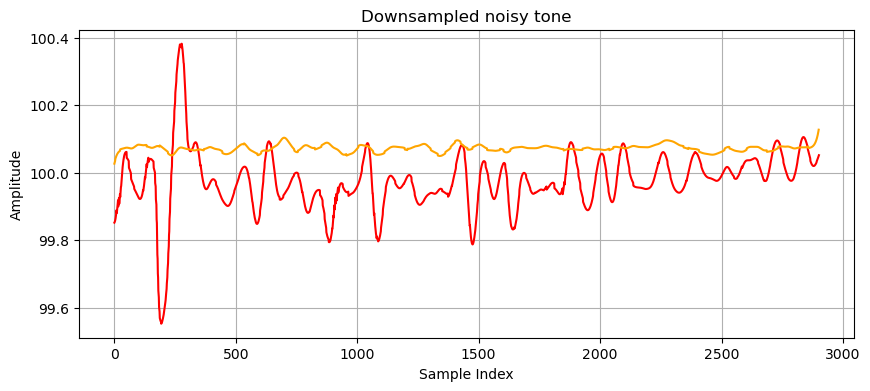

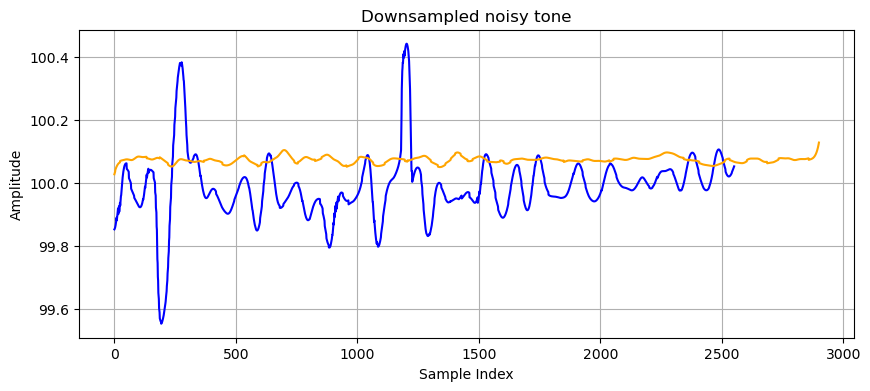

In [5]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(bandpass_sig_cut, cut_noise_fs, 100, 20_000, 50)
freqs_DFT1 = segmented_freq_estimation_DFT1(bandpass_sig, noise_fs, 100, 20_000, 50)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 50)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

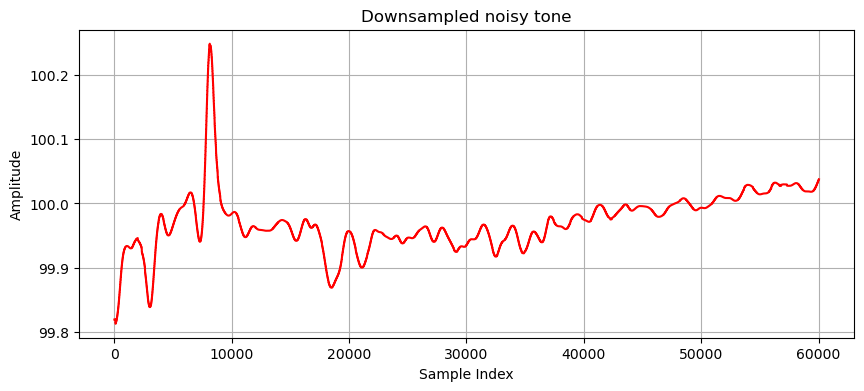

2.9884993811745106e-07


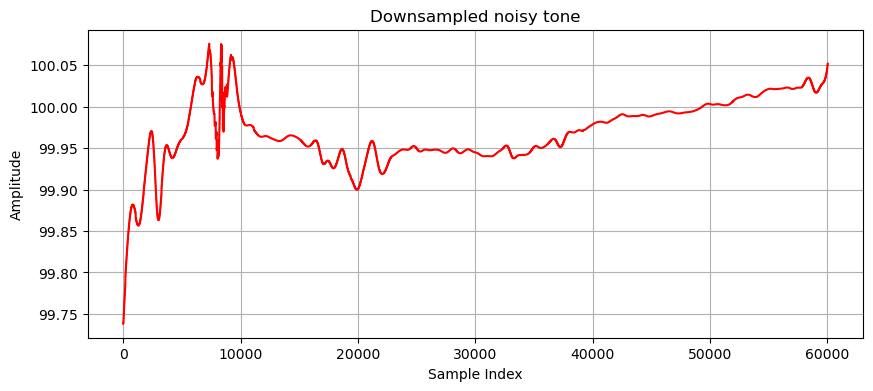

1.1606036054803167e-07


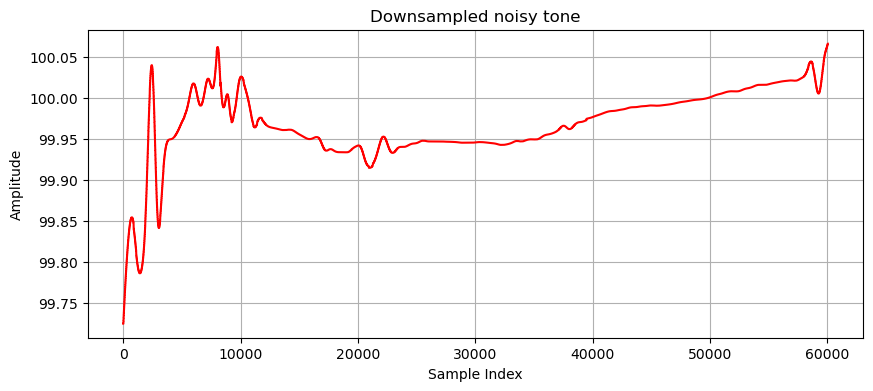

3.6466266254367993e-08


In [6]:
fs = noise_fs
f0 = 100
I = 3
epsilon = 1e-20
tau = int(2500)

denoised_signal = RFA(bandpass_sig, noise_fs, tau, epsilon, I, f0)

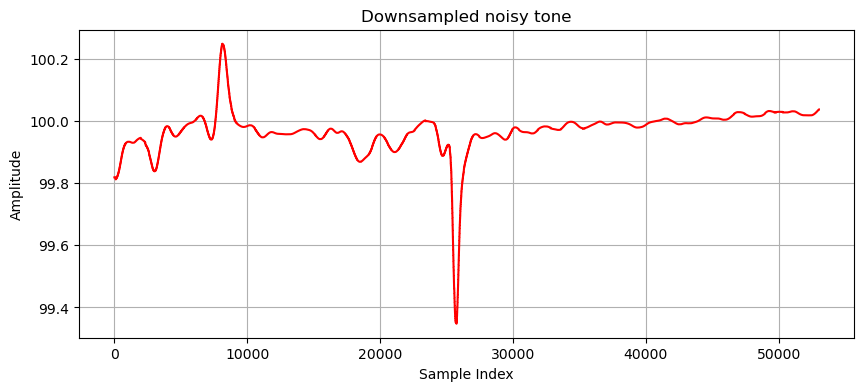

6.378586703817932e-07


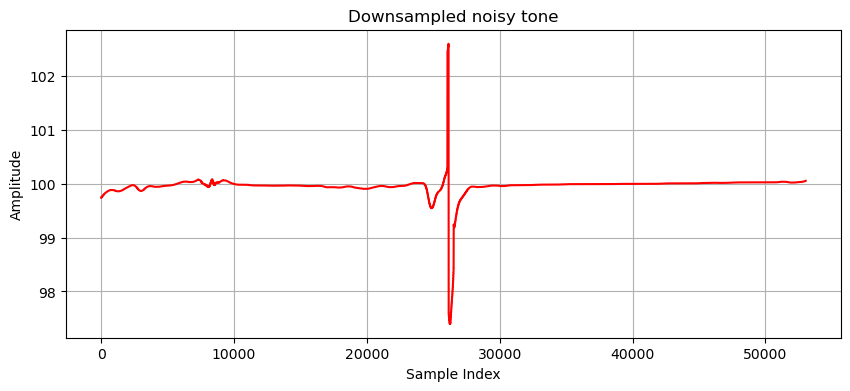

5.378055465935707e-06


In [14]:
fs = noise_fs
f0 = 100
I = 2
epsilon = 1e-20
tau = int(2500)

cut_denoised_signal = RFA(bandpass_sig_cut, cut_noise_fs, tau, epsilon, I, f0)

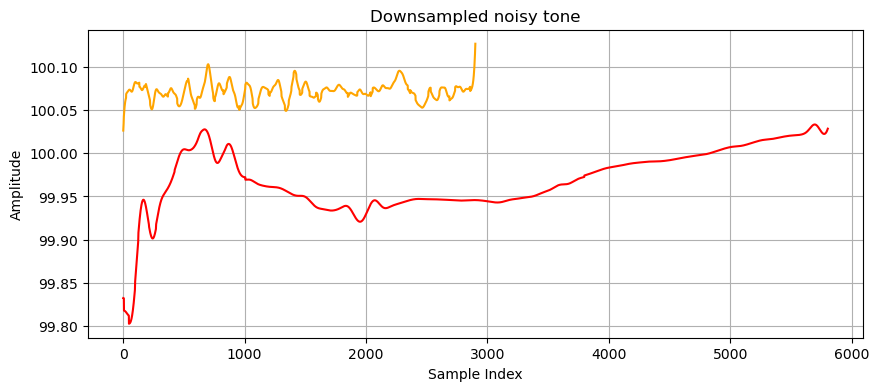

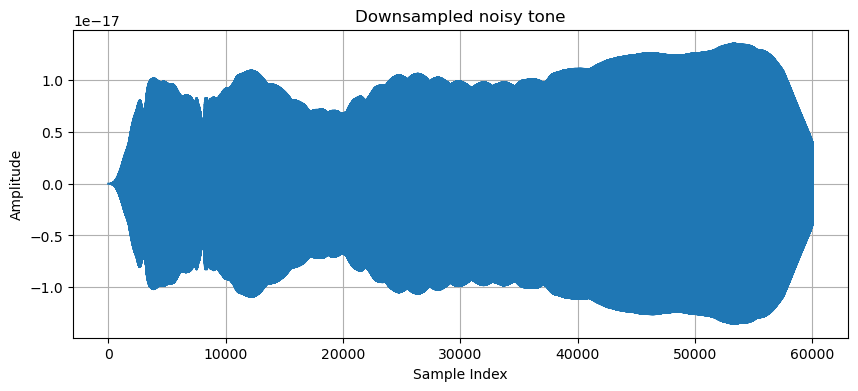

60032
60032


In [9]:
freqs_DFT1 = segmented_freq_estimation_DFT1(denoised_signal, noise_fs, 200, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(denoised_signal)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(denoised_signal))
print(len(bandpass_sig))

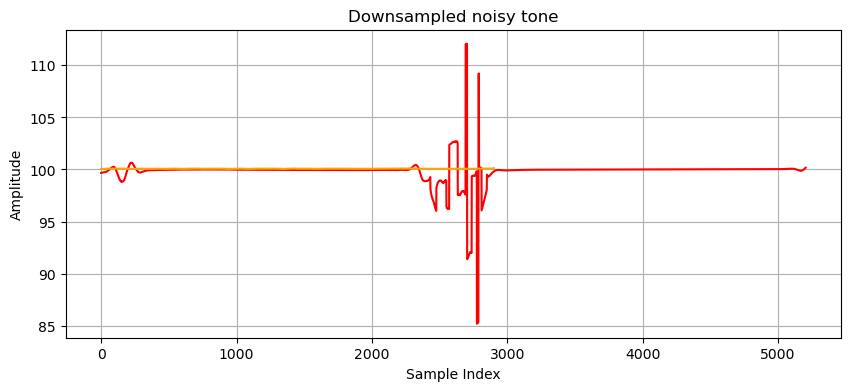

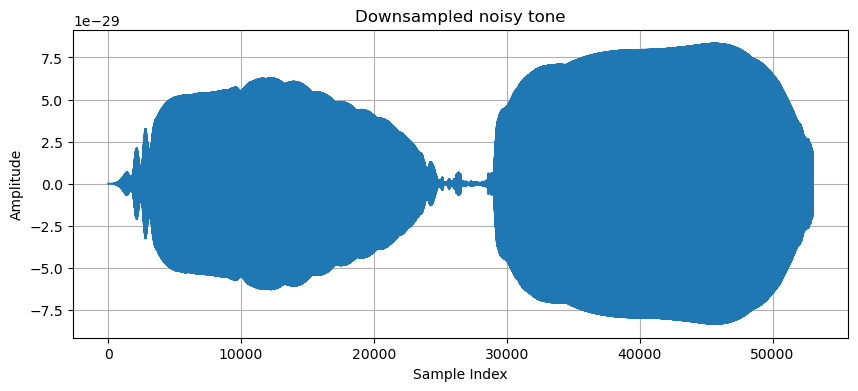

53032
53032


In [11]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(cut_denoised_signal, cut_noise_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cut_denoised_signal)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(cut_denoised_signal))
print(len(bandpass_sig_cut))

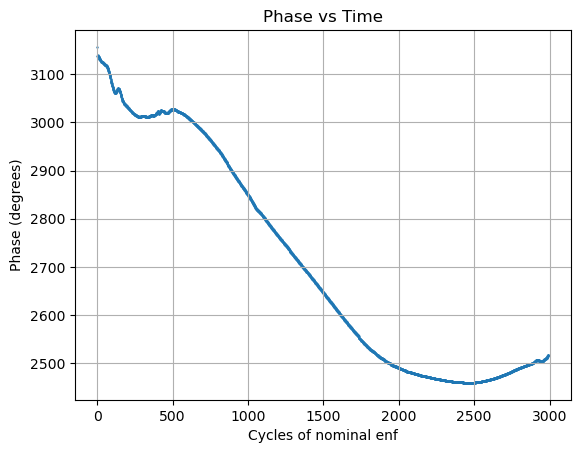

In [12]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised = segmented_phase_estimation_hilbert(denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised = np.unwrap(phases_denoised)

x_denoised = np.arange(len(phases_denoised))
plt.scatter(x_denoised, np.degrees(phases_denoised), s= 0.5)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

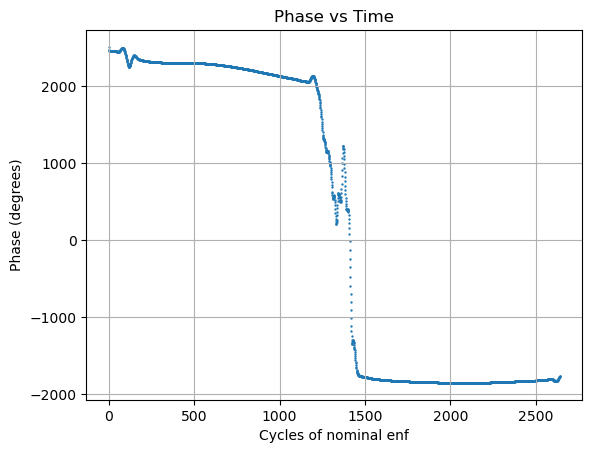

In [13]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised_cut = segmented_phase_estimation_hilbert(cut_denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised_cut = np.unwrap(phases_denoised_cut)

x_denoised_cut = np.arange(len(phases_denoised_cut))
plt.scatter(x_denoised_cut, np.degrees(phases_denoised_cut), s= 0.5)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

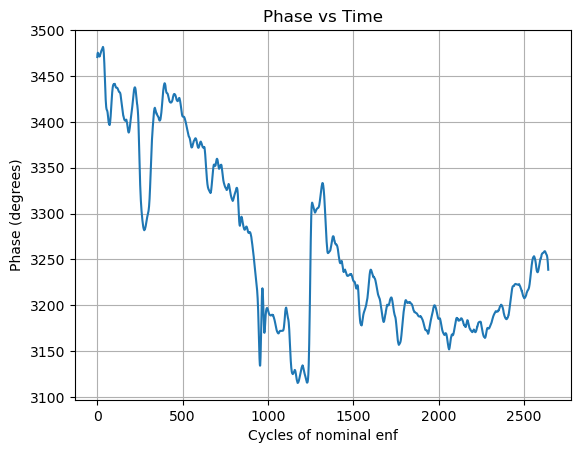

In [13]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_cut = segmented_phase_estimation_hilbert(bandpass_sig_cut, fs, NUM_CYCLES, 50)
phases_cut = np.unwrap(phases_cut)

x_cut = np.arange(len(phases_cut))
plt.plot(x_cut, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

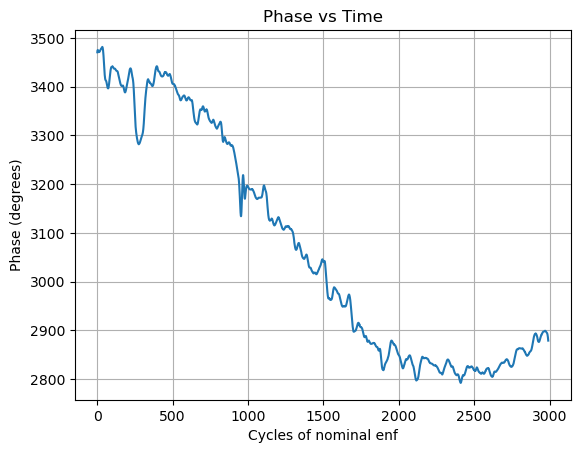

In [14]:
N_DFT = 20_000
NUM_CYCLES = 10

phases = segmented_phase_estimation_hilbert(bandpass_sig, fs, NUM_CYCLES, 50)
phases = np.unwrap(phases)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

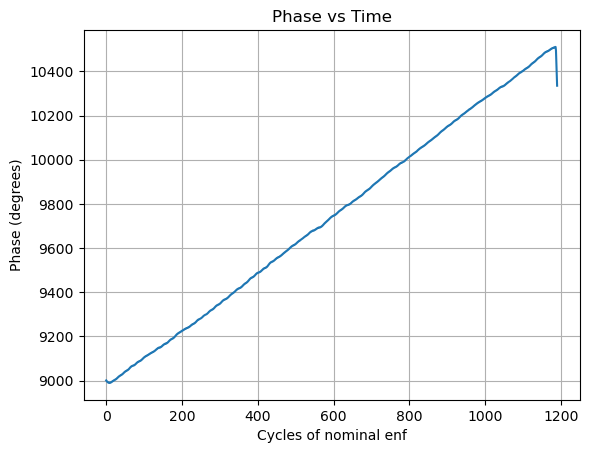

In [15]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_ref = segmented_phase_estimation_hilbert(bandpass_ref, fs, NUM_CYCLES, 50)
phases_ref = np.unwrap(phases_ref)

x_ref = np.arange(len(phases_ref))
plt.plot(x_ref, np.degrees(phases_ref))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

In [16]:
def find_cut_in_phases(phases, x):
    """_summary_

    Args:
        phases (_type_): _description_
        x (_type_): _description_

    Returns:
        _type_: _description_
    """

    range_threshold = 20
    window_size = 10
    second_der = np.gradient(np.gradient(phases, x), x)

    plt.scatter(x, second_der, s=10)
    plt.xlabel("Cycles of nominal enf")
    plt.ylabel("second derivative")
    plt.title("Second derivative")
    plt.grid(True)
    plt.show()

    z_scores = np.abs(stats.zscore(second_der))
    outliers = np.array(np.where(z_scores > 5))

    plt.scatter(x, z_scores, s=10)
    plt.xlabel("Cycles of nominal enf")
    plt.ylabel("second derivative")
    plt.title("Second derivative")
    plt.grid(True)
    plt.show()

    if not np.any(outliers):
        return phases, x, outliers

    else:
        discontinuities = []
        i = 0

        while i < len(outliers[0]) - 1:
            start = outliers[0][i]
            while (
                i < len(outliers[0]) - 1
                and (outliers[0][i + 1] - outliers[0][i]) <= range_threshold
            ):
                i += 1
            end = outliers[0][i]

            # Search for the cut discontinuitites
            if end - start >= window_size:
                segment = second_der[start : end + 1]
                pos_count = np.sum(segment > 0)
                neg_count = np.sum(segment < 0)

                if pos_count > 0 and neg_count > 0:
                    discontinuities.append((start, end))

            i += 1

        discontinuities = np.array(discontinuities)

        if not np.any(discontinuities):
            return phases, x, discontinuities

        start = discontinuities[0][0]
        end = discontinuities[0][1]

        phases_new = phases[int(start) - 200 : int(end) + 200]
        x_new = x[int(start) - 200 : int(end) + 200]

        return phases_new, x_new, discontinuities

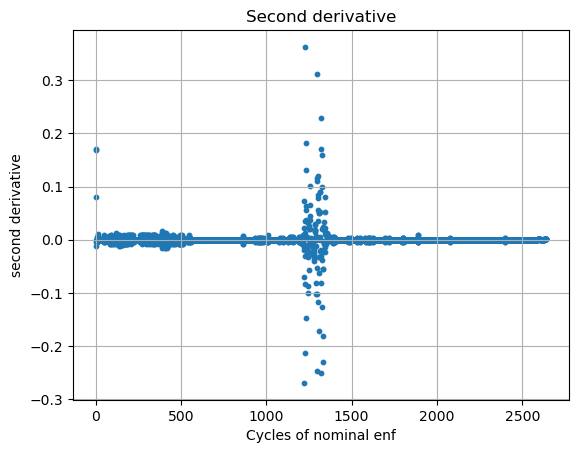

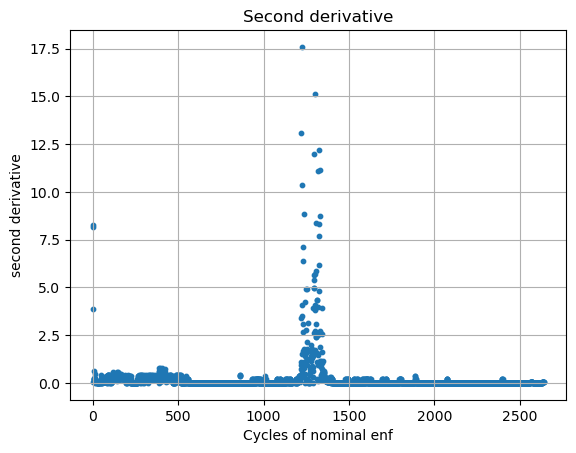

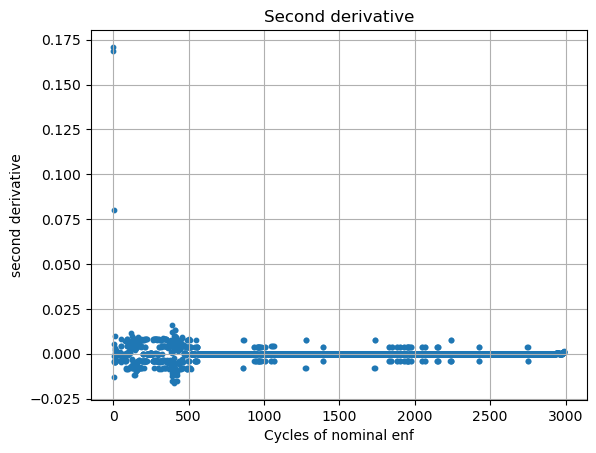

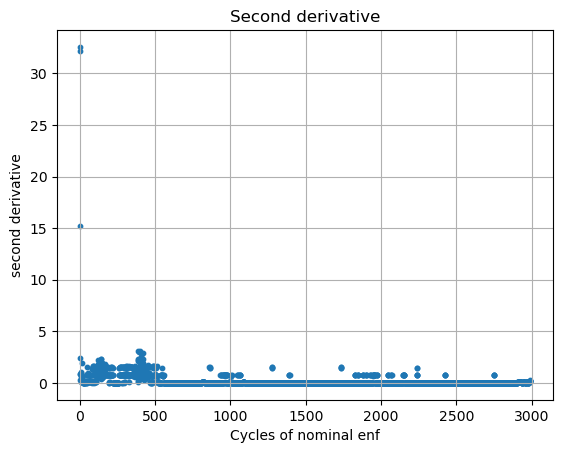

In [20]:
phases_cut, x_cut, cut_discontinuities = find_cut_in_phases(phases_denoised_cut, x_denoised_cut)
phases, x, discontinuities = find_cut_in_phases(phases_denoised, x_denoised)